# Controller Monitoring

Visualize controller performance on mainnet

In [1]:
import os
import time
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from web3 import Web3, HTTPProvider

size = 15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,12),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}

plt.rcParams.update(params)

Gather Data

In [2]:
# Need an archive node
ETH_RPC_URL=os.environ['ETH_RPC_URL']

In [3]:
# UpdateRedemptionRate events come from the rate setter
GEB_RRFM_SETTER="0x7Acfc14dBF2decD1c9213Db32AE7784626daEb48"

# Will retrive sg, ag, pscl from rate calc
GEB_RRFM_CALCULATOR="0xddA334de7A9C57A641616492175ca203Ba8Cf981"
# new scaled controller
NEW_GEB_RRFM_CALCULATOR="0x5CC4878eA3E6323FdA34b3D28551E1543DEe54C6"


In [4]:
# import abis
from abis.abis import GEB_RRFM_SETTER_ABI, GEB_RRFM_CALCULATOR_ABI

In [5]:
w3 = Web3(Web3.HTTPProvider(ETH_RPC_URL, request_kwargs={"timeout": 10}))
rate_setter = w3.eth.contract(address=GEB_RRFM_SETTER, abi=GEB_RRFM_SETTER_ABI)
rate_calc = w3.eth.contract(address=GEB_RRFM_CALCULATOR, abi=GEB_RRFM_CALCULATOR_ABI)
new_rate_calc = w3.eth.contract(address=NEW_GEB_RRFM_CALCULATOR, abi=GEB_RRFM_CALCULATOR_ABI)

calc_deploy_block = 14226200
new_calc_deploy_block = 15046690

first_block = calc_deploy_block
last_block = 'latest'

update_rr_filter = {'fromBlock': first_block, 'toBlock': last_block, 'address': GEB_RRFM_SETTER,
                     'topics': ['0x16abce12916e67b821a9cdabe7103d806d6f4280a69d5830925b3e34c83f52a8']}
logs = w3.eth.get_logs(update_rr_filter)

results = []
for log in logs:
    event = []
    p_log = rate_setter.events.UpdateRedemptionRate().processLog(log)
    
    event.append(p_log['args']['marketPrice'])
    event.append(p_log['args']['redemptionPrice'])
    event.append(p_log['args']['redemptionRate'])
    event.append(p_log['transactionHash'].hex())
    event.append(p_log['address'])
    event.append(p_log['blockNumber'])
    ts = w3.eth.get_block(p_log['blockNumber'])['timestamp']

    # Rate calc variables
    if p_log['blockNumber'] < new_calc_deploy_block: 
        current_rate_calc = rate_calc
    else:
        current_rate_calc = new_rate_calc
        
    prop_term = current_rate_calc.caller(block_identifier=p_log['blockNumber']).getLastProportionalTerm()
    integral_term = current_rate_calc.caller(block_identifier=p_log['blockNumber']).getLastIntegralTerm()
    sg = current_rate_calc.caller(block_identifier=p_log['blockNumber']).sg()
    ag = current_rate_calc.caller(block_identifier=p_log['blockNumber']).ag()
    pscl = current_rate_calc.caller(block_identifier=p_log['blockNumber']).pscl()

    event.append(ts)
    event.append(prop_term)
    event.append(integral_term)
    event.append(sg)
    event.append(ag)
    event.append(pscl)
    results.append(event)

Create dataframe

In [6]:
df = pd.DataFrame(results, columns=['marketPrice', 'redemptionPrice', 'redemptionRate', 'transactionHash',\
                                    'address', 'blockNumber', 'ts', 'prop_term', 'integral_term', 'sg', 'ag', 'pscl'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   marketPrice      274 non-null    object
 1   redemptionPrice  274 non-null    object
 2   redemptionRate   274 non-null    object
 3   transactionHash  274 non-null    object
 4   address          274 non-null    object
 5   blockNumber      274 non-null    int64 
 6   ts               274 non-null    int64 
 7   prop_term        274 non-null    object
 8   integral_term    274 non-null    object
 9   sg               274 non-null    int64 
 10  ag               274 non-null    int64 
 11  pscl             274 non-null    object
dtypes: int64(4), object(8)
memory usage: 25.8+ KB


In [8]:
df.tail(2)

,marketPrice,redemptionPrice,redemptionRate,transactionHash,address,blockNumber,ts,prop_term,integral_term,sg,ag,pscl
272,2986760290000000000000000000,2937688154529128125080634887,999999992719789450148728971,0xb2d411599a20f85c206c4bd4cbcb9269d80ebf77aa47...,0x7Acfc14dBF2decD1c9213Db32AE7784626daEb48,15102370,1657289652,-16704337863505283394670047,-50278866788977616108432255337040,222002205862,71040,999999711200000000000000000
273,2984806560000000000000000000,2936748988155547984695081930,999999992788729865762336784,0x0b6447aec2bc55641685a17a5f8168a642e3b63d0a4e...,0x7Acfc14dBF2decD1c9213Db32AE7784626daEb48,15105706,1657333572,-16364208190171204274475154,-50371337539902154842676472854392,222002205862,71040,999999711200000000000000000


In [9]:
df['timestamp'] = pd.to_datetime(df['ts'], unit='s')

In [10]:
df = df.set_index('timestamp')

In [ ]:
# these are delta rates, not per-second rates
df['p_rate_delta'] = (df['prop_term'] * df['sg'])/1e18
df['i_rate_delta'] = (df['integral_term'] * df['ag'])/1e18

In [32]:
df['p_rate_delta'].tail(3)

timestamp
2022-07-08 01:56:09   -4.010378e+18
2022-07-08 14:14:12   -3.708400e+18
2022-07-09 02:26:12   -3.632890e+18
Name: p_rate_delta, dtype: float64

In [13]:


# create total per-second rate
df['total_rate'] = (1e27 + df['p_rate_delta'] + df['i_rate_delta'])

# convert these to per-second rates
df['p_rate'] = 1e27 + df['p_rate_delta']
df['i_rate'] = 1e27 + df['i_rate_delta']

In [14]:
# calculate annual rates
df['redemptionRate_apy'] = (df['redemptionRate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
df['total_rate_apy'] = (df['total_rate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
df['p_rate_apy'] = (df['p_rate'].apply(lambda x: Decimal(int(x))).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
df['i_rate_apy'] = (df['i_rate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100

In [15]:
df['apy_diff'] = df['redemptionRate_apy'] - df['total_rate_apy']

Convert for plotting

In [16]:
df['marketPrice'] = df['marketPrice'].apply(lambda x: int(x)/1e27)
df['redemptionPrice'] = df['redemptionPrice'].apply(lambda x: int(x)/1e27)

In [17]:
df['total_rate_apy'] = df['total_rate_apy'].apply(float)
df['p_rate_apy'] = df['p_rate_apy'].apply(float)
df['i_rate_apy'] = df['i_rate_apy'].apply(float)

df['p_rate_delta'] = df['p_rate_delta'].apply(float)
df['i_rate_delta'] = df['i_rate_delta'].apply(float)

Plot total, p and i rates

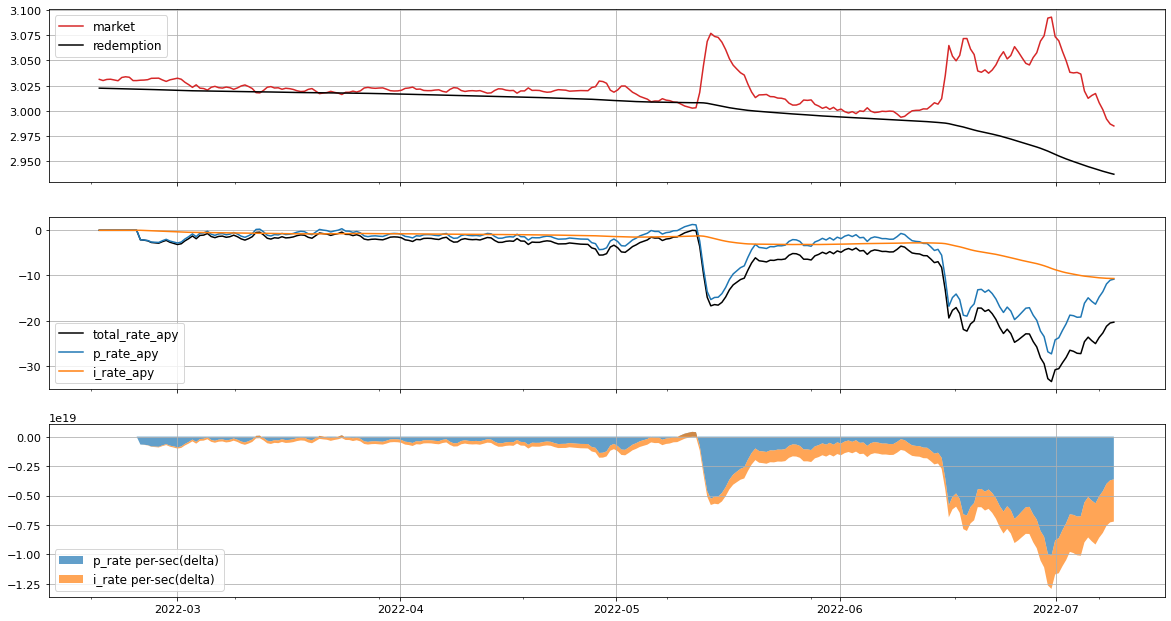

In [18]:
fig, ax = plt.subplots(3, 1, sharex=True)
#ax[0].plot(df[['marketPrice', 'redemptionPrice']], label=['market', 'redemption'], colors=['#d62728', 'black'])
ax[0].plot(df[['marketPrice']], label='market', color='#d62728')
ax[0].plot(df[['redemptionPrice']], label='redemption', color='black')
ax[0].legend()
ax[0].grid()


df[['total_rate_apy', 'p_rate_apy', 'i_rate_apy']].plot(ax=ax[1], color=['black', '#1f77b4', '#ff7f0e'])
ax[1].grid()

ax[2].stackplot(df.index, df['p_rate_delta'], df['i_rate_delta'], baseline='zero', alpha=0.7,
                labels=['p_rate per-sec(delta)', 'i_rate per-sec(delta)'])
ax[2].legend(loc='lower left')
ax[2].grid()

plt.savefig('output/controller_monitoring.png', facecolor='white', transparent=False)
plt.show()

In [19]:
df.to_csv('output/final_data.csv')

In [20]:
# get defauly color cycle
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [21]:
df.tail(2)

,marketPrice,redemptionPrice,redemptionRate,transactionHash,address,blockNumber,ts,prop_term,integral_term,sg,...,p_rate_delta,i_rate_delta,total_rate,p_rate,i_rate,redemptionRate_apy,total_rate_apy,p_rate_apy,i_rate_apy,apy_diff
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-08 14:14:12,2.986760,2.937688,999999992719789450148728971,0xb2d411599a20f85c206c4bd4cbcb9269d80ebf77aa47...,0x7Acfc14dBF2decD1c9213Db32AE7784626daEb48,15102370,1657289652,-16704337863505283394670047,-50278866788977616108432255337040,222002205862,...,-3.708400e+18,-3.571811e+18,999999992719789516082118656.0,999999996291600180473495552.0,999999996428189348896178176.0,-20.51395554272066186060370319,-20.513955,-11.036863,-10.652830,-1.6527337643863590119E-7
2022-07-09 02:26:12,2.984807,2.936749,999999992788729865762336784,0x0b6447aec2bc55641685a17a5f8168a642e3b63d0a4e...,0x7Acfc14dBF2decD1c9213Db32AE7784626daEb48,15105706,1657333572,-16364208190171204274475154,-50371337539902154842676472854392,222002205862,...,-3.632890e+18,-3.578380e+18,999999992788729857216348160.0,999999996367109691266826240.0,999999996421620179237076992.0,-20.34095654817015901955083932,-20.340957,-10.824766,-10.671338,2.146861399482085678E-8


In [311]:
kp = df['sg'].iloc[-1] # WAD
ki = df['ag'].iloc[-1] # WAD
alpha = df['pscl'].iloc[-1]
prop_term = df['prop_term'].iloc[-1] # RAY
integral_term = df['integral_term'].iloc[-1]# RAY
last_ts = int(df['ts'].iloc[-1])

last_market_price = df['marketPrice'].iloc[-1]
last_redemption_price = df['redemptionPrice'].iloc[-1]

last_redemption_rate = df['redemptionRate'].iloc[-1] # RAY, per-sec

In [312]:
print(f"{kp=}")
print(f"{ki=}")
print(f"{alpha=}")
print(f"{prop_term=}")
print(f"{integral_term=}")
print(f"{last_redemption_rate=}")

kp=222002205862
ki=71040
alpha=999999711200000000000000000
prop_term=-16364208190171204274475154
integral_term=-50371337539902154842676472854392
last_redemption_rate=999999992788729865762336784


In [343]:
WAD = 1E18
RAY = 1E27
class RAI():
    def __init__(self, redemption_price, redemption_rate, last_update_time,
                 kp, ki, alpha, prop_term=0, integral_term=0):
        
        self.redemption_price = redemption_price
        self.redemption_rate = redemption_rate
        self.last_update_time = last_update_time
        
        self.kp = kp # WAD
        self.ki = ki # WAD
        self.alpha = alpha # RAY
        self.integral_term = integral_term # RAY
        self.prop_term = prop_term # RAY
        
        self.ki_rate = None
        self.kp_rate = None
           
    def update_rp(self, time_since):
        self.redemption_price = Decimal(self.redemption_price) * (Decimal(self.redemption_rate)/Decimal(RAY))**time_since
        
    def process(self, market_price, ts):
        # Parameters:
        # Error: RAY
        # Time_since: secs
        
        # Returns
        # pRate: Ray
        # iRate: Ray
        # rp: float
        
        time_since = ts - self.last_update_time
        
        self.update_rp(time_since)
        
        error = int(((self.redemption_price - Decimal(market_price))/self.redemption_price)* Decimal(RAY))
        
        # computer pRate
        self.kp_rate = self.kp/WAD * error
        
        # calculate new area as a trapezoid
        new_area = (error + self.prop_term) / 2   * time_since
        
        #print(f"{new_area=}")
        
        # decay factor for old area
        decay = (Decimal(self.alpha)/Decimal(RAY)) ** Decimal(time_since)
        
        #print(f"{self.integral_term=}")
        #print(f"{decay=}")
        
        # decay old error
        decayed_sum = self.integral_term * decay
        
        #print(f"{decayed_sum=}")
        
        self.integral_term = int(float(decayed_sum + Decimal(new_area)))
        #print(f"{self.integral_term=}")
        
        # computer iRate
        self.ki_rate = self.ki/WAD * self.integral_term
        
        # set this error as old error to use for next trapezoid
        self.prop_term = error
        self.last_update_time = ts
        
        rate_lower_bound = 999999934241503702775225172
        rate_upper_bound = 1000000065758500621404894451 
        self.redemption_rate = min(max(1e27 + self.kp_rate + self.ki_rate, rate_lower_bound), rate_upper_bound)
        
        
        return ts, self.redemption_rate, self.kp_rate, self.ki_rate, self.redemption_price, market_price
    

In [344]:
rai = RAI(last_redemption_price, last_redemption_rate, last_ts, kp, ki, alpha, prop_term, integral_term)

In [345]:
ts, total_rate, new_kp, new_ki, rp, mp = rai.process(3.00, last_ts + 12*3600)

In [346]:
print(ts, new_kp, new_ki, rp, mp)

1657376772 -4.852091713968787e+18 -3.592660327352501e+18 2.935834254420365264348751929 3.0


In [347]:
(1+new_kp/RAY)**(86400*365)

0.8581163650248641

In [348]:
(1+new_ki/RAY)**(86400*365)

0.8928844205071491

In [349]:
N_STEPS = 200
UPDATE_INTERVAL = 12 * 3600

In [334]:
# Constant Market Prices
results_e = []
market_prices = [last_market_price for _ in range(N_STEPS)]
timestamps = [last_ts + i*UPDATE_INTERVAL for i in range(1, N_STEPS + 1)]

rai = RAI(last_redemption_price, last_redemption_rate, last_ts, kp, ki, alpha, prop_term, integral_term)
for i, mp in enumerate(market_prices):
    ts, total_rate, p_rate, i_rate, rp, mp = rai.process(mp, int(timestamps[i]))
    results_e.append((ts, total_rate, p_rate, i_rate, rp, mp))

In [335]:
# Converged Market Prices
rai = RAI(last_redemption_price, last_redemption_rate, last_ts, kp, ki, alpha, prop_term, integral_term)
results_conv = []
for ts in timestamps:
    ts, total_rate, p_rate, i_rate, rp, mp = rai.process(rai.redemption_price, int(ts))
    results_conv.append((ts, total_rate, p_rate, i_rate, rp, mp))

So iRate_sec=0.90^(1/(86400*365))

# pRate_sec must cancel iRate_sec to create a zero rate.
pRate_sec=1 + (1-iRate_sec)
pRate_sec=1 + (1 -(0.90^(1/(86400*365))))

pRate_sec=1 + (1 -0.9999999966590)
pRate_sec=2-0.9999999966590
pRate_sec=1.000000003341
#kp, ki create 'delta rates' , not per_sec rates. . rate_delta=rate_sec-1
so
pRate_delta = pRate_sec -1
Since kp*error=pRate_delta
kp*error=1.000000003341 - 1 = 0.000000003341
error=0.000000003341/2.25e-7
error=0.0148


error = (redemption-market)/redemption
error * rp = rp - mp
mp= rp- error * rp

In [356]:
# Zero rate market prices
rai = RAI(last_redemption_price, last_redemption_rate, last_ts, kp, ki, alpha, prop_term, integral_term)
results_zero = []
for ts in timestamps:
    # current iRate(delta)
    ki_rate = rai.ki/WAD * rai.integral_term
    # current pRate(Delta)
    
    kp_rate = rai.kp/WAD * rai.prop_term

    nec_prop_term = -ki_rate/rai.kp * WAD
    
    #print(rai.prop_term, nec_prop_term)
    #kp_rate = kp * error
    needed_error = -ki_rate/rai.kp/WAD
    #print(ki_rate, needed_error)
    input_mp = float(rai.redemption_price) - (nec_prop_term/1e27 * float(rai.redemption_price))
    #print(input_mp)
    ts, total_rate, p_rate, i_rate, rp, mp = rai.process(input_mp, int(ts))
    results_zero.append((ts, total_rate, p_rate, i_rate, rp, mp))

In [322]:
def post_process(results):
    df = pd.DataFrame(results, columns=['ts', 'total_rate', 'p_rate_delta', 'i_rate_delta', 'redemptionPrice', 'marketPrice'])
    df['timestamp'] = pd.to_datetime(df['ts'], unit='s')
    df = df.set_index('timestamp')
    
    # create total per-second rate
    #df['total_rate'] = (1e27 + df['p_rate_delta'] + df['i_rate_delta'])

    # convert these to per-second rates
    df['p_rate'] = 1e27 + df['p_rate_delta']
    df['i_rate'] = 1e27 + df['i_rate_delta']
    
    df['total_rate_apy'] = (df['total_rate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
    df['p_rate_apy'] = (df['p_rate'].apply(lambda x: Decimal(int(x))).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100
    df['i_rate_apy'] = (df['i_rate'].apply(Decimal).apply(lambda x: (x/Decimal(1e27))**(86400*365)) - 1) * 100

    df['total_rate_apy'] = df['total_rate_apy'].apply(float)
    df['p_rate_apy'] = df['p_rate_apy'].apply(float)
    df['i_rate_apy'] = df['i_rate_apy'].apply(float)

    df['p_rate_delta'] = df['p_rate_delta'].apply(float)
    df['i_rate_delta'] = df['i_rate_delta'].apply(float)  
    
    return df

In [357]:
df_e = post_process(results_e)

In [358]:
df_conv = post_process(results_conv)

In [359]:
df_zero= post_process(results_zero)

In [360]:
merged_e = pd.concat([df, df_e], axis=0, ignore_index=True) 
merged_conv = pd.concat([df, df_conv], axis=0, ignore_index=True) 
merged_zero = pd.concat([df, df_zero], axis=0, ignore_index=True) 

merged_e['timestamp'] = pd.to_datetime(merged_e['ts'], unit='s')
merged_e = merged_e.set_index('timestamp')

merged_conv['timestamp'] = pd.to_datetime(merged_conv['ts'], unit='s')
merged_conv = merged_conv.set_index('timestamp')

merged_zero['timestamp'] = pd.to_datetime(merged_zero['ts'], unit='s')
merged_zero = merged_zero.set_index('timestamp')


In [382]:
def plot(df, title):
    fig, ax = plt.subplots(3, 1, sharex=True)

    ax[0].plot(df[['marketPrice']], label='market', color='#d62728')
    ax[0].plot(df[['redemptionPrice']], label='redemption', color='black', alpha=0.5)
    ax[0].legend()
    ax[0].grid()


    df[['total_rate_apy', 'p_rate_apy', 'i_rate_apy']].plot(ax=ax[1], color=['black', '#1f77b4', '#ff7f0e'])
    ax[1].grid()

    #ax[2].stackplot(df.index, df['p_rate_delta'], df['i_rate_delta'], baseline='zero', alpha=0.7,
    #               labels=['p_rate per-sec(delta)', 'i_rate per-sec(delta)'])
    
    ax[2].stackplot(df.index, df['p_rate_delta'], baseline='zero', alpha=0.7,
                   labels=['p_rate per-sec(delta)'])
    
    ax[2].stackplot(df.index, df['i_rate_delta'], baseline='zero', alpha=0.7,
                   labels=['i_rate per-sec(delta)'])
    
    
    ax[2].legend(loc='lower left')
    ax[2].grid()

    #plt.savefig('output/controller_monitoring.png', facecolor='white', transparent=False)
    plt.suptitle(title, size=25)
    #plt.tight_layout()
    plt.show()

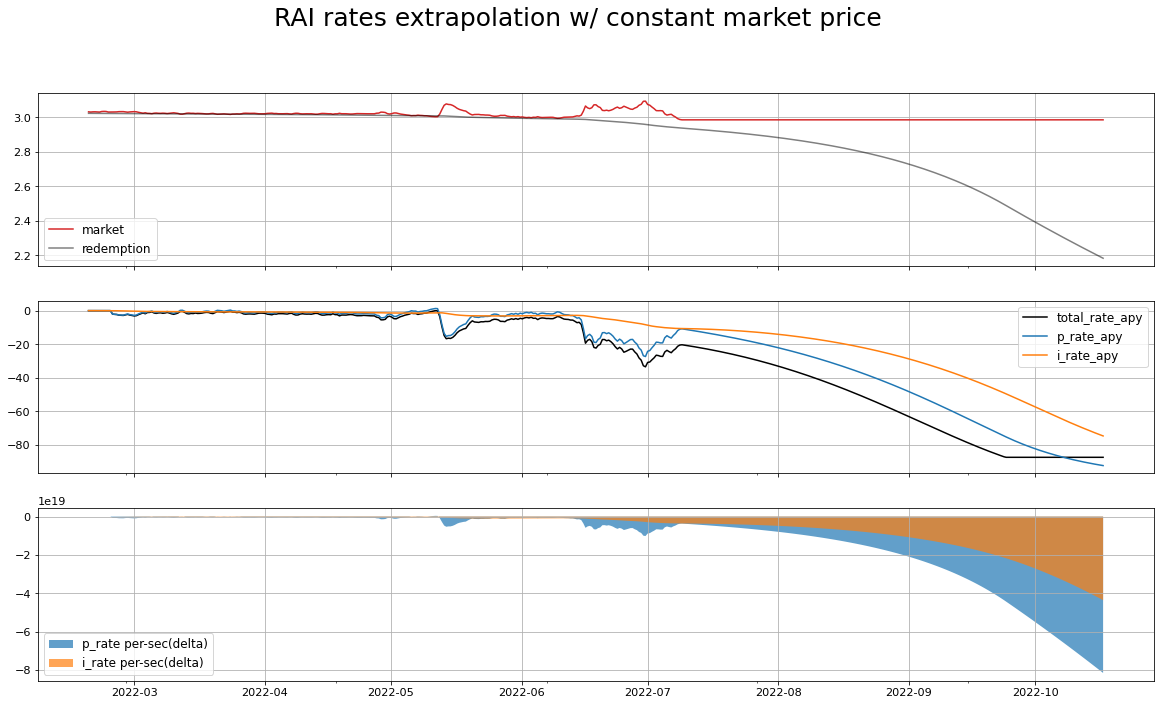

In [383]:
plot(merged_e, "RAI rates extrapolation w/ constant market price")

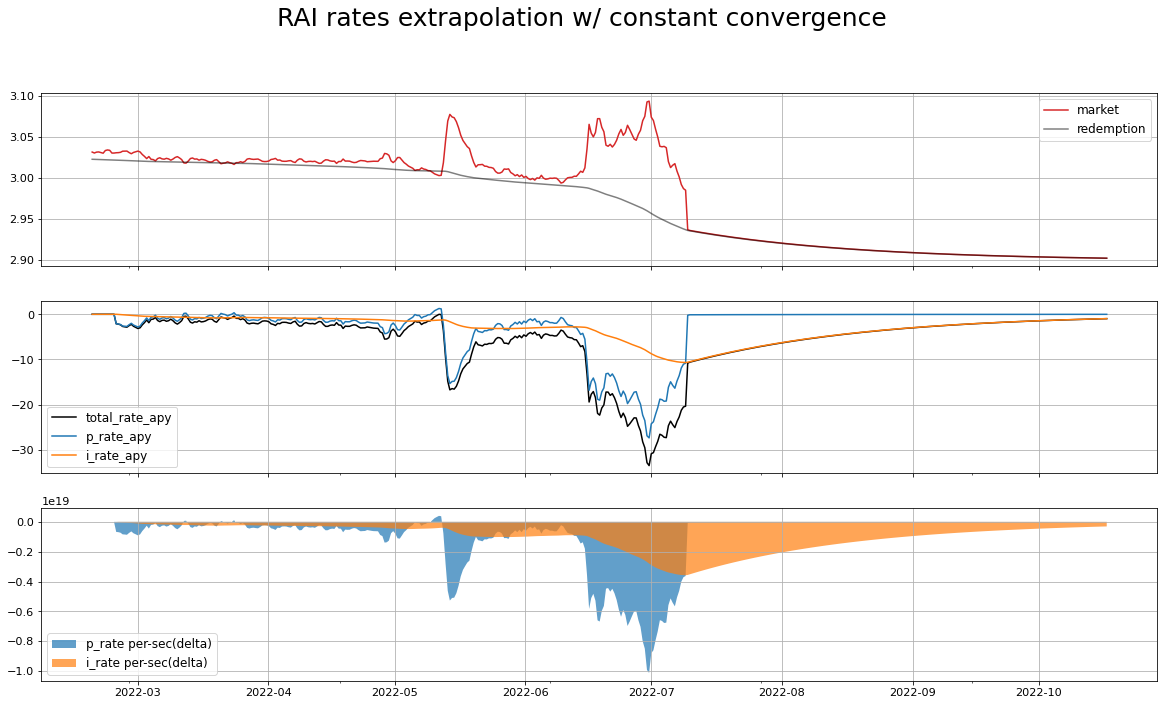

In [384]:
plot(merged_conv, "RAI rates extrapolation w/ constant convergence")

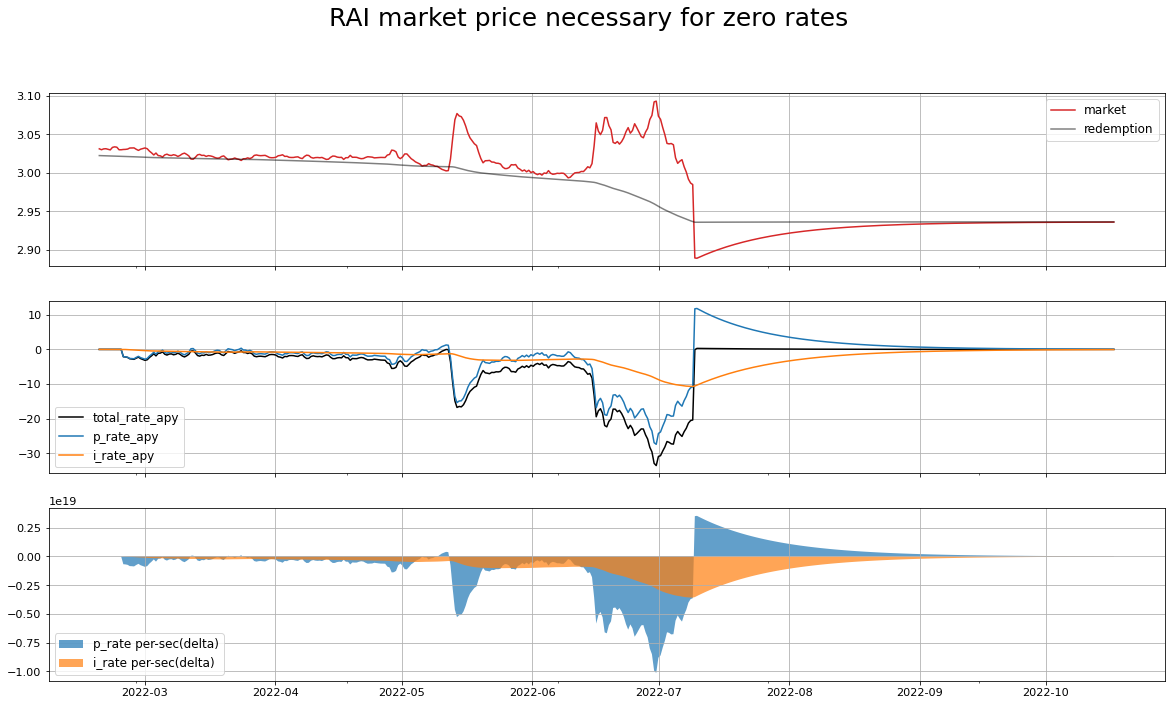

In [385]:
plot(merged_zero, "RAI market price necessary for zero rates")